In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


In [2]:
ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}


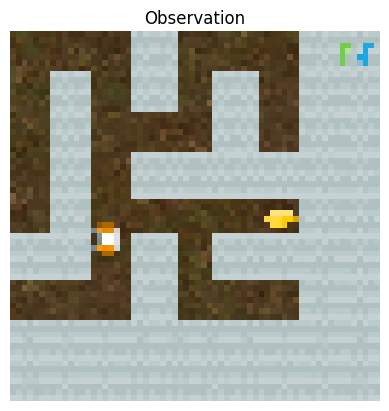

[]
[0.]
Count rewards 0 out of total episodes: 1/1


In [18]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering


model_path = "../model_final.pt"
modification_value = -2
total_episodes = 1
best_layer = None
best_score = 0
layer_number = 14


count_rewards_0 = 0
for episode in range(total_episodes):
    filepath=f'episode_steering_{episode}.gif'
    total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
    print(total_reward_steering)
    if total_reward_steering == 0:
        count_rewards_0 += 1


print(f"Count rewards 0 out of total episodes: {count_rewards_0}/{total_episodes}")

    

In [4]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(observations[-1])
    
    
    if total_reward == 0: return True

    

    else: return False

{'x': StateValue(val=6.380231857299805, idx=13932), 'y': StateValue(val=0.40637728571891785, idx=13936), 'vx': StateValue(val=0.0, idx=13940), 'vy': StateValue(val=0.0, idx=13944), 'rx': StateValue(val=0.375, idx=13948), 'ry': StateValue(val=0.2321428656578064, idx=13952), 'type': StateValue(val=2, idx=13956), 'image_type': StateValue(val=2, idx=13960), 'image_theme': StateValue(val=0, idx=13964), 'render_z': StateValue(val=0, idx=13968), 'will_erase': StateValue(val=0, idx=13972), 'collides_with_entities': StateValue(val=0, idx=13976), 'collision_margin': StateValue(val=0.0, idx=13980), 'rotation': StateValue(val=0.0, idx=13984), 'vrot': StateValue(val=0.0, idx=13988), 'is_reflected': StateValue(val=0, idx=13992), 'fire_time': StateValue(val=-1, idx=13996), 'spawn_time': StateValue(val=-1, idx=14000), 'life_time': StateValue(val=0, idx=14004), 'expire_time': StateValue(val=-1, idx=14008), 'use_abs_coords': StateValue(val=0, idx=14012), 'friction': StateValue(val=1.0, idx=14016), 'smar

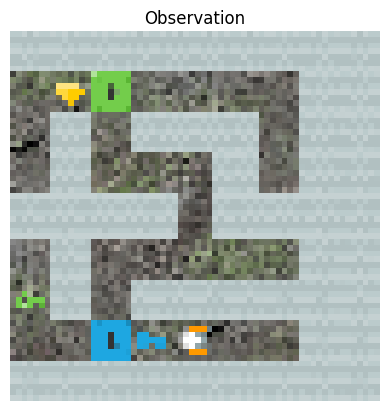

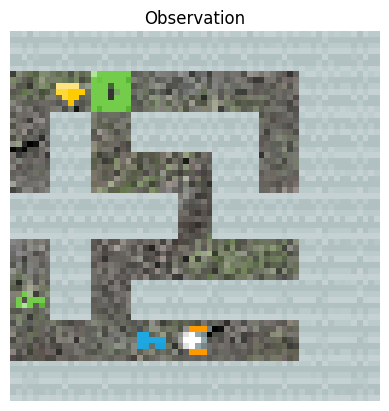

[{'x': StateValue(val=nan, idx=13961), 'y': StateValue(val=nan, idx=13965), 'vx': StateValue(val=0.0, idx=13969), 'vy': StateValue(val=0.0, idx=13973), 'rx': StateValue(val=0.5, idx=13977), 'ry': StateValue(val=0.5, idx=13981), 'type': StateValue(val=1, idx=13985), 'image_type': StateValue(val=1, idx=13989), 'image_theme': StateValue(val=0, idx=13993), 'render_z': StateValue(val=0, idx=13997), 'will_erase': StateValue(val=0, idx=14001), 'collides_with_entities': StateValue(val=0, idx=14005), 'collision_margin': StateValue(val=0.0, idx=14009), 'rotation': StateValue(val=0.0, idx=14013), 'vrot': StateValue(val=0.0, idx=14017), 'is_reflected': StateValue(val=0, idx=14021), 'fire_time': StateValue(val=-1, idx=14025), 'spawn_time': StateValue(val=-1, idx=14029), 'life_time': StateValue(val=0, idx=14033), 'expire_time': StateValue(val=-1, idx=14037), 'use_abs_coords': StateValue(val=0, idx=14041), 'friction': StateValue(val=1.0, idx=14045), 'smart_step': StateValue(val=0, idx=14049), 'avoids

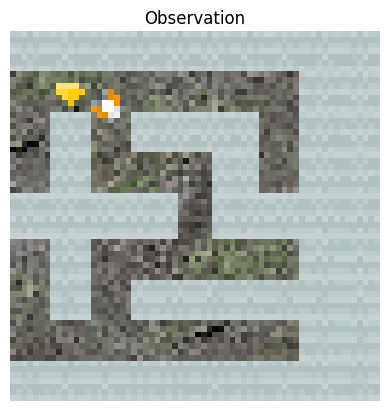

False

In [5]:
model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
layer_number = 14
save_gif = False
episode_timeout = 200
num_levels=1


venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()
state_values = state.state_vals
key_positions = heist.get_keys(state_values)

while True:
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))

    state = heist.state_from_venv(venv, 0)

    unchanged_obs = venv.reset()

    state_values = state.state_vals

    key_positions = heist.get_keys(state_values)

    if key_positions.get(1) != None:
        print("Green key detected!")
        break

# delete blue key
state.delete_key(0)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_blue_key = venv.reset()

# Add the key back to the environment
print(f"initial: {key_positions}" )

state.set_key_position(0,key_positions[0]["x"],key_positions[0]["y"])
key_positions = heist.get_keys(state_values)


# delete the green key
state.delete_key(1)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_green_key = venv.reset()

# Add the key back to the environment
state.set_key_position(1,key_positions[1]["x"], key_positions[1]["y"])

state.delete_specific_locks([0])

state_bytes = state.state_bytes
venv.env.callmethod("set_state", [state_bytes])

state = heist.state_from_venv(venv, 0)
key_positions = heist.get_keys(state.state_vals)
print(f"later: {key_positions}" )


layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations_no_blue = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_blue_key), layer_names)
model_activations.clear_hooks()
output3, modified_obs_activations_no_green = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_green_key), layer_names)

steering_vector_blue_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_blue[steering_layer][0]

steering_vector_green_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_green[steering_layer][0]

scaled_steering_vector_blue_key = -2 * steering_vector_blue_key
# scaled_steering_vector_green_key = 1 * steering_vector_green_key

# Combine the scaled steering vectors
# combined_steering_vector = scaled_steering_vector_blue_key + scaled_steering_vector_green_key



modification_value = 1
helpers.plot_single_observation(helpers.tensor_to_image(unchanged_obs))
helpers.plot_single_observation(helpers.tensor_to_image(venv.reset()))

run_episode_with_steering_and_check_target_acquisition(
    venv, model, steering_vector=scaled_steering_vector_blue_key, steering_layer=ordered_layer_names[layer_number],
    modification_value=modification_value, filepath=f'episode_double_steering.gif',
    save_gif=True, episode_timeout=episode_timeout
)





## Testing vector fields visualisation



In [86]:
import matplotlib.pyplot as plt
import torch
import helpers
import heist
# from procgen_tools import  visualisation
import procgen_tools.visualization as visualisation
# from heist import create_venv, load_model, get_legal_mouse_positions, vector_field_tup, plot_vf

# Load the model
model_path = "../../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)

# Create the environment
venv = heist.create_venv(num=1, start_level=0, num_levels=1)

# Get the state and legal mouse positions
state = heist.state_from_venv(venv, 0)
full_grid = state.full_grid(with_mouse=False)
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, state.state_vals["ents"])

# Generate the vector field
vf = visualisation.vector_field_tup(venv, legal_mouse_positions, full_grid, model)

# Plot the vector field
fig, ax = plt.subplots(figsize=(10, 10))
plot_vf(vf, ax=ax, human_render=True, render_padding=False)
plt.show()

torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [70]:
from typing import List, Tuple, Dict, Union, Optional, Callable
import re
from collections import defaultdict
import pickle
import funcy as fn

import numpy as np
import pandas as pd
import torch as t
import math

import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm import tqdm
from einops import *
from IPython.display import *
from ipywidgets import *
from ipywidgets import interact
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

import circrl.hooks as cmh
import circrl.rollouts as cro

import procgen_tools.models as models
import procgen_tools.utils as utils
from procgen import ProcgenGym3Env

import os, sys
from glob import glob
from pathlib import Path

from ipywidgets import (
    Text,
)  # Import this later because otherwise Text gets cast as str?

RAND_REGION = 5
NUM_ACTIONS = 15
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
# PATH_PREFIX = '../' if in_jupyter else ''


def load_model(rand_region: int = 5, num_actions: int = 15, use_small: bool = False):
    """Load a model from the trained_models folder. Returns the policy and the HookManager."""
    import os
    print(os.getcwd())
    model_stub = f"../../model_9501.0.pt"
    try:
        utils.cd_into_procgen_tools()
    except Exception:
        Path("procgen-tools").mkdir(parents=True, exist_ok=True)
        os.chdir("procgen-tools")
    policy = models.load_policy(model_stub, num_actions, t.device("cpu"))
    manager = cmh.HookManager(policy, cache=['conv_seqs.1.res_block0.conv0.weight'])
    return policy, manager

policy, manager = load_model(rand_region=RAND_REGION, num_actions=NUM_ACTIONS, use_small=False)


/Users/bensturgeon/werk/ai-safety-camp-2024-model-agents/notebooks/procgen-tools


In [68]:
manager = cmh.HookManager(policy)

hook = manager._make_cache_hook('conv_seqs.1.res_block0.conv0.weight')
dir(hook)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [ ]:
  def get_submodule(module, submodule_name):
    names = submodule_name.split('.')
    for name in names:
        module = getattr(module, name)
    return module
    
    for name in layer_names:
        layer = get_submodule(model, name)
        hook = make_hook(name)  # Create a hook with a stable layer name
        self.hooks.append(layer.register_forward_hook(hook))

In [55]:
import circrl.hooks as cmh
dir(cmh.HookManager)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_make_cache_hook',
 '_make_func_hook',
 '_make_patch_hook']

In [59]:
manager = cmh.HookManager(policy)
hook = manager._make_cache_hook('conv_seqs.1.res_block0.conv0.weight')

NameError: name 'policy' is not defined

In [46]:
venv = heist.create_venv(num=1, start_level=0, num_levels=1)
obs = venv.reset()

if not isinstance(obs, torch.Tensor):
        obs = torch.tensor(obs, dtype=torch.float32)


# Check the shape of the input and reshape if necessary
# if obs.shape == torch.Size([1, 3, 64, 64]):
#         obs = obs.squeeze(0)  # Remove the batch dimension
# if obs.shape == torch.Size([3, 64, 64]):
#         obs = obs.permute(1, 2, 0)  # Switch dimensions to (64, 64, 3)
print(obs.shape)
with torch.no_grad():
        dummy_input = torch.zeros(1, 64, 64, 3)  # Adjust the input shape as needed
        output = model(dummy_input)
        print(output)
        input_dim = output.shape[1]

torch.Size([1, 3, 64, 64])
(Categorical(logits: torch.Size([1, 15])), tensor([[8.0971]]))


AttributeError: 'tuple' object has no attribute 'shape'

In [20]:
import os
os.getcwd()

'/Users/bensturgeon/werk/ai-safety-camp-2024-model-agents/notebooks/procgen-tools'

In [25]:
model.state_dict()['conv_seqs.1.res_block0.conv0.weight'].shape[0]//16


2

In [29]:
model.state_dict()


OrderedDict([('conv_seqs.0.conv.weight',
              tensor([[[[ 1.6808e-01, -1.2271e-01,  1.2103e-01],
                        [-8.2378e-02, -2.1941e-01,  1.2876e-01],
                        [-1.3471e-01, -3.5367e-04, -8.2066e-02]],
              
                       [[-1.2410e-01,  5.9326e-02, -1.9607e-02],
                        [ 8.1824e-03, -8.6282e-02,  5.8218e-02],
                        [ 2.2476e-01, -8.2421e-03, -1.0261e-01]],
              
                       [[ 5.9310e-02,  2.4609e-02, -8.5418e-02],
                        [-6.6543e-02,  2.1795e-01,  5.1424e-02],
                        [ 1.0376e-01,  1.4039e-01,  1.5666e-02]]],
              
              
                      [[[-5.2321e-02, -1.2187e-01,  7.0631e-02],
                        [ 3.5816e-02, -1.0881e-01, -1.6337e-02],
                        [-8.9034e-02,  7.3558e-02,  1.7225e-02]],
              
                       [[ 1.7192e-01,  4.8262e-02, -3.1518e-04],
                        [-4.4107e-